In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import ast
from termcolor import colored
import string
from nltk.tokenize import word_tokenize 
import string
from tqdm import trange

sns.set_style('darkgrid')

# For my jupyter theme
%config InlineBackend.print_figure_kwargs = {'facecolor':'white'}

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torch.cuda.current_device(), torch.cuda.get_device_name(0)

if torch.cuda.is_available():  
    dev = 'cuda:0' 
else:  
    dev = 'cpu'
#dev = 'cpu'

## Resumen:

1. Quitando símbolos tóxicos (", espacios, !, etc) tenemos los siguientes resultados:
  - LSTM: *train*=0.6386, *test*=0.5886 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
2. Quitando símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - LSTM: *train*=0.6386, *test*=0.5886 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
  
3. Sin quitar símbolos tóxicos (", espacios, !, etc), es decir, dataset original:
  - LSTM: *train*=0.570, *test*=0.531 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
  
4. Sin quitar símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - LSTM: *train*=0.570, *test*=0.531 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
  
Para la LSTM lo mejor parece ser la opción 1. Lo mejor hasta ahora es con `(EMBEDDING_DIM = 20 HIDDEN_DIM = 20 EPOCHS = 25)` (test=0.581, aunque no se fijó la semilla y no se puede reproducir).

## Preprocesamiento

In [3]:
from utils import (color_toxic_words, remove_symbols, completely_toxic, separate_words, 
                   get_index_toxic_words, f1)

In [4]:
train = pd.read_csv('Datos/tsd_train.csv', converters={'spans':ast.literal_eval})
test = pd.read_csv('Datos/tsd_trial.csv', converters={'spans':ast.literal_eval})

In [5]:
train['spans_clean'] = train['spans']
test['spans_clean'] = test['spans']

In [6]:
# Pondremos los que tienen [ ] como completamente tóxicos para ver qué sale.

clean_spans = [completely_toxic(span, text) for (span, text) in zip(train['spans'], train['text'])]
train['spans_clean'] = clean_spans

clean_spans = [completely_toxic(span, text) for (span, text) in zip(test['spans'], test['text'])]
test['spans_clean'] = clean_spans

In [7]:
# Quitamos símbolos

indices_clean = [remove_symbols(index, text) for index,text in zip(train['spans'], train['text'])]
train['spans_clean'] = indices_clean

indices_clean = [remove_symbols(index, text) for index,text in zip(test['spans'], test['text'])]
test['spans_clean'] = indices_clean

In [8]:
# Pasamos a minúscula
train['text'] = train['text'].apply(lambda x:x.lower())

# Pasamos a minúscula
test['text'] = test['text'].apply(lambda x:x.lower())

## Cargar embeddings

In [9]:
from torchtext.data import Field


text_field = Field(
    tokenize='basic_english', 
    lower=True
)
label_field = Field(sequential=False, use_vocab=False)
# sadly have to apply preprocess manually
preprocessed_text = train['text'].apply(lambda x: text_field.preprocess(x))
# load fastext simple embedding with 300d
text_field.build_vocab(
    preprocessed_text, 
    vectors='glove.twitter.27B.200d'
)
# get the vocab instance
vocab = text_field.vocab

/home/mario/anaconda3/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [10]:
vocab.lookup_indices(['another', 'violent', 'and', 'aggressive', 'immigrant', 'killing', 'a', 'innocent', 'and', 'intelligent', 'us', 'citizen', '....', 'sarcasm'])


[126, 1322, 6, 3243, 2117, 412, 7, 796, 6, 1014, 85, 1085, 0, 3944]

from torchtext.vocab import GloVe
embedding_glove = GloVe(name='6B', dim=100)

In [11]:
train['spans_clean'][0]

[8,
 9,
 10,
 11,
 12,
 13,
 14,
 16,
 17,
 18,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

In [12]:
train.iloc[0]

spans          [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...
text           another violent and aggressive immigrant killi...
spans_clean    [8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21,...
Name: 0, dtype: object

## LSTM

In [13]:
train_data = []
for index, text in zip(train['spans_clean'], train['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    train_data.append((tokens, tagged_tokens, text, index))

In [14]:
train_data

[(['another',
   'violent',
   'and',
   'aggressive',
   'immigrant',
   'killing',
   'a',
   'innocent',
   'and',
   'intelligent',
   'us',
   'citizen',
   '....',
   'sarcasm'],
  ['non_toxic',
   'toxic',
   'toxic',
   'toxic',
   'toxic',
   'non_toxic',
   'non_toxic',
   'non_toxic',
   'non_toxic',
   'non_toxic',
   'non_toxic',
   'non_toxic',
   'non_toxic',
   'non_toxic'],
  'another violent and aggressive immigrant killing a innocent and intelligent us citizen.... sarcasm',
  [8,
   9,
   10,
   11,
   12,
   13,
   14,
   16,
   17,
   18,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39]),
 (['i',
   'am',
   '56',
   'years',
   'old',
   ',',
   'i',
   'am',
   'not',
   'your',
   'fucking',
   'junior',
   'pal',
   '.',
   'what',
   'you',
   'are',
   'saying',
   'makes',
   'no',
   'sense',
   '.',
   'i',
   'do',
   "n't",
   'know',
   'what',
   'you',
   'are',
   'ba

In [15]:
test_data = []
for index, text in zip(test['spans'], test['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    test_data.append((tokens, tagged_tokens, text, index))

In [16]:
def prepare_sequence(seq):
    idxs = vocab.lookup_indices(seq)      # Si no está que lo ponga como 'UNK'
    return torch.tensor(idxs, dtype=torch.long, device=dev)
def prepare_sequence_tags(seq):
    tag_to_ix = {"non_toxic": 0, "toxic": 1} 
    idxs = [tag_to_ix[s] for s in seq]
    return torch.tensor(idxs, dtype=torch.long, device=dev)

In [17]:
from torch.utils.data import Dataset, DataLoader


class SpansDataset(Dataset):
    """Spans dataset."""

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        text = prepare_sequence(self.data[idx][0])
        spans = prepare_sequence_tags(self.data[idx][1])
        sample = {'tokenized' : self.data[idx][0], 'original_text' : self.data[idx][2], 'text': text, 'spans': spans, 'true_index' : self.data[idx][3]}

        return sample

In [18]:
train_size = len(train_data)
test_size = len(test_data)

train_ds = SpansDataset(train_data)
test_ds = SpansDataset(test_data)

trainloader = DataLoader(train_ds, batch_size=1, shuffle=True)
#Test is dev in reality
testloader = DataLoader(test_ds, batch_size=1, shuffle=True)

In [19]:
"""
word_to_ix = {'UNK': 0}

for sent, tags in train_data:
    for word in sent:
        if word not in word_to_ix:              # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
"""            
tag_to_ix = {"non_toxic": 0, "toxic": 1}        # Assign each tag with a unique index

In [20]:
from torch import autograd
"""
try2
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, weight, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Usar otro embedding, tratar con alguno que haya en 'transformers'
        self.word_embeddings = nn.Embedding.from_pretrained(weight)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, dropout=0.05, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores
"""
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, stacked_layers, dropout_p, weight, hidden_dim, vocab_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.stacked_layers = stacked_layers
        self.word_embeddings = nn.Embedding.from_pretrained(weight)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = stacked_layers,
                            dropout = dropout_p,
                            bidirectional = True)

        # Linear layers
        self.fc1 = nn.Linear(hidden_dim*2, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        output, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        x = F.relu(self.fc1(output.view(len(sentence), -1)))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [21]:
def get_index_toxic_words(sentence, tagged_sentence):
    toxic_indices = []   
    m = 0
    #tag_to_ix = {"non_toxic": 0, "toxic": 1}
    for word_tag in tagged_sentence:
        word, tag = word_tag    
        if tag == 1:#toxic
            # Si la palabra tóxica aparece 2 o más veces ésto solo dará la primera 
            # aparición, hay que arreglar eso pero por lo mientras sirve
            # word_indices = [sentence.find(word) + i for i in range(len(word))]
            # toxic_indices.append(word_indices)
            
            # Así parece evitarf1_torch el problema de la palabra repetida
            word_indices = [m + sentence[m:].find(word) + i for i in range(len(word))]
            toxic_indices.append(word_indices)
            m += sentence[m:].find(word) + len(word) + 1
            
    toxic_indices = [val for sublist in toxic_indices for val in sublist]
    #Unir espacios y otras cosas para que suba el F1    
    return toxic_indices


def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)

def f1_scores(pred, true_index, tokenized, text):
    scores_LSTM = 0
    for i in range(len(pred)):
        tags = [1 if x > 0.5 else 0 for x in pred[i]]
        tagged_sentence = list(zip(tokenized[i], tags))
        prediction_index = get_index_toxic_words(text[i], tagged_sentence)
        scores_LSTM += f1(prediction_index, true_index[i])
    return scores_LSTM/len(pred)

def plot_loss_and_score(train_loss, test_loss, f1_scores_train, f1_scores_test, show=True):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

    ax0.plot(np.arange(1, len(train_loss) + 1), train_loss, marker='o', label='train_loss')
    ax0.plot(np.arange(1, len(test_loss) + 1), test_loss, marker='o', label='validation loss')
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('Loss')
    ax0.legend()

    ax1.plot(np.arange(1, len(f1_scores_train) + 1), f1_scores_train, 
             marker='o', label='f1 score in train')
    ax1.plot(np.arange(1, len(f1_scores_test) + 1), f1_scores_test, 
             marker='o', label='f1 score in test')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('F1 score')
    ax1.legend()

    if show:
        plt.show()

In [22]:
"""
HIDDEN_DIM = 250
embedding_dim = len(vocab.vectors[0])
model = LSTMTagger(embedding_dim, vocab.vectors, HIDDEN_DIM, len(vocab.vectors), len(tag_to_ix))
model.to(torch.device(dev))
"""
"""
#try3
HIDDEN_DIM = 600
embedding_dim = len(vocab.vectors[0])
model = LSTMTagger(embedding_dim, 6, 0.15, vocab.vectors, HIDDEN_DIM, len(vocab.vectors), len(tag_to_ix))
model.to(torch.device(dev))
"""
#try4
HIDDEN_DIM = 600
embedding_dim = len(vocab.vectors[0])
model = LSTMTagger(embedding_dim, 6, 0.15, vocab.vectors, HIDDEN_DIM, len(vocab.vectors))
model.to(torch.device(dev))

LSTMTagger(
  (word_embeddings): Embedding(20566, 200)
  (lstm): LSTM(200, 600, num_layers=6, dropout=0.15, bidirectional=True)
  (fc1): Linear(in_features=1200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)

In [23]:
#model = torch.load('best-model-try2.pt').to(torch.device(dev))

In [24]:
import torch.optim as optim

criterion = nn.BCELoss()
#optimizer = optim.SGD(model.parameters(), momentum = 0.85, lr=0.002, weight_decay=1e-9)
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay = 1e-8)

In [25]:
loss_per_epoch = [0]
training_loss = [0]
f1_scores_train = [0]
f1_scores_dev = [0]
stop_after_best = 100
best_l = None
best_tl = None
worst_l = 0
worst_tl = 0
worst_l_f1 = 0
best_l_f1 = None
worst_tl_f1 = 0
last_epoch_save = 0

Training on: GeForce GTX 1080
###############################################
Current epoch: 1
Last model save was in epoch 0
Stopping training in: 100 epochs.
###############################################
[Best iter] test F1 is: None
[Best iter] dev F1 is: None
###############################################
[Last iter] training F1 was: 0
[Last iter] dev. F1 was: 0
###############################################


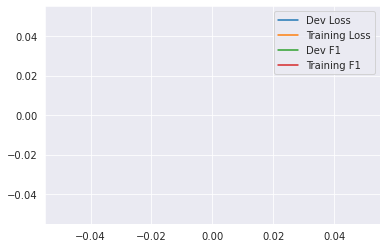

Sentence 0 done.
Sentence 1000 done.
Sentence 2000 done.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

stop_after_best = 100
#Nombre del archivo de backup
savefile = 'best-model-try4.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 100 épocas
    display.clear_output(wait=True)
    print("Training on: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] test F1 is: " + str(best_tl))
    print("[Best iter] dev F1 is: " + str(best_l))
    print("###############################################")
    print("[Last iter] training F1 was: " + str(f1_scores_train[-1]))
    print("[Last iter] dev. F1 was: " + str(f1_scores_dev[-1]))
    print("###############################################")
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.plot(range(epochs), f1_scores_dev)
    plt.plot(range(epochs), f1_scores_train)
    plt.legend(["Dev Loss", "Training Loss", "Dev F1", "Training F1"])
    plt.show()
    tl = 0
    t_pred_l = []
    t_true_index_l = []
    t_tokenized_l = []
    t_text_l = []
    for i, v in enumerate(trainloader): #Not using batches yet
        text = torch.reshape(v['text'], (-1,))
        tags = torch.reshape(v['spans'], (-1,))
        optimizer.zero_grad()
        tag_scores = model(text)
        
        t_pred_l.append(tag_scores.cpu().detach().numpy())
        t_true_index_l.append([a.cpu().detach().numpy()[0] for a in v['true_index']])
        t_tokenized_l.append([a[0] for a in v['tokenized']])
        t_text_l.append(v['original_text'][0])
        loss = criterion(torch.reshape(tag_scores, (-1,)), torch.reshape(tags, (-1,)).float())
        tl += loss.item()
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print("Sentence {} done.".format(i))
    tl /= len(trainloader)
    l = 0
    print("Starting evaluation for loss function.")
    #evaluar el modelo
    pred_l = []
    true_index_l = []
    tokenized_l = []
    text_l = []
    
    model.eval()
    with torch.no_grad():
        for v in testloader:
            text = torch.reshape(v['text'], (-1,))
            tags = torch.reshape(v['spans'], (-1,))

            tag_scores = model(text)
            
            pred_l.append(tag_scores.cpu().detach().numpy())
            true_index_l.append([a.cpu().detach().numpy()[0] for a in v['true_index']])
            tokenized_l.append([a[0] for a in v['tokenized']])
            text_l.append(v['original_text'][0])
            
            loss = criterion(torch.reshape(tag_scores, (-1,)), torch.reshape(tags, (-1,)).float())
            l += loss.item()
    model.train()
    l /= len(testloader)
    print("Starting evaluation for dev F1")
    f1_d = f1_scores(pred_l, true_index_l, tokenized_l, text_l)
    f1_t = f1_scores(t_pred_l, t_true_index_l, t_tokenized_l, t_text_l)
    
    epochs_without_change += 1
    if best_l is None or best_l < f1_d:
        print("Model improved, saving.")
        torch.save(model, savefile)
        best_l = f1_d
        best_tl = f1_t
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    #Para graficar con una escala coherente.
    if(f1_d < worst_l_f1):
        worst_l_f1 = f1_d
        f1_scores_dev[0] = worst_l_f1
    if(f1_t < worst_tl_f1):
        worst_tl_f1 = f1_t
        f1_scores_train[0] = worst_tl_f1
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl
    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    f1_scores_train.append(f1_t)
    f1_scores_dev.append(f1_d)
    #Rastreo la época actual
    epochs += 1
print('Finished Training')

In [ ]:
plot_loss_and_score(train_loss, test_loss, f1_scores_train, f1_scores_test, show=False)
plt.title('train-f1: {:.4f} \n test-f1: {:.4f}'.format(np.max(f1_scores_train), np.max(f1_scores_test)))
plt.savefig('Images/preprocesamiento-4.png', bbox_inches='tight')
plt.show()

## Evaluación

In [ ]:
model = torch.load(savefile)
model.eval()

In [ ]:
evaluation = pd.read_csv('Datos/tsd_test.csv')
evaluation.head()

In [ ]:
indices_evaluation = []
for text in evaluation['text']:
    tagged_sentence = tagger_LSTM(text)   
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    indices_evaluation.append(prediction_index)
    print(colored('Pred: ', color='cyan', attrs=['bold']) + 
           color_toxic_words(prediction_index, text)) 

In [ ]:
evaluation['spans'] = indices_evaluation
evaluation = evaluation[['spans', 'text']]
evaluation.head()

Para la evaluación se debe subir un zip con un archivo txt de la siguiente manera (al final subir el archivo `spans-pred.zip` que se produce):

In [20]:
predictions = evaluation['spans'].tolist()
ids = evaluation.index.tolist()

with open("spans-pred.txt", "w") as out:
    for uid, text_scores in zip(ids, predictions):
        out.write(f"{str(uid)}\t{str(text_scores)}\n")
        
# Zip the predictions
! zip -r spans-pred.zip ./spans-pred.* 

updating: spans-pred.txt (deflated 82%)
